In [6]:
import json
import os
from typing import NamedTuple


import cv2
import numpy as np
from scipy.optimize import linear_sum_assignment as lsa
import shapely.geometry


DIR = os.path.join('track-results-sort')
BBoxType = tuple[int, int, int, int, int]


class MatchedDetection(NamedTuple):
    tid: int
    did: int


def construct_track(render: list[tuple[int, list[BBoxType]]]):
    tracks: dict[int, list[BBoxType]] = {}
    for fid, dets in render:
        for oid, *box in dets:
            if oid not in tracks:
                tracks[oid] = []
            tracks[oid].append((fid, box[0], box[1], box[2], box[3]))
    return tracks


def find_iou(box1: list[int], box2: list[int]):
    assert len(box1) == len(box2) == 4, (box1, box2)
    b1 = shapely.geometry.box(box1[0], box1[1], box1[2], box1[3])
    b2 = shapely.geometry.box(box2[0], box2[1], box2[2], box2[3])
    intersection = b1.intersection(b2).area
    union = b1.union(b2).area
    return intersection / union

In [7]:
with open(os.path.join(DIR, 'jnc00.mp4.r.1.jsonl'), 'r') as f:
    gt = [json.loads(line) for line in f]

# Construct gt tracks
# gt = construct_track(rendergt)
cap = cv2.VideoCapture(os.path.join('video-masked', 'jnc00.mp4'))
frame = cap.read()[1]
height, width, _ = frame.shape

max_track = np.ones(((height // 128) + 1, (width // 128) + 1), dtype=int)
min_misstrack = np.ones(((height // 128) + 1, (width // 128) + 1), dtype=int)
min_misstrack.fill(1000)

# For each skipping size
for filename in os.listdir(DIR):
    if not filename.startswith('jnc00') or not filename.endswith('.jsonl') or '.r.' not in filename:
        continue
    print(filename)
        
    skip = int(filename.split('.')[3])
    gt_ = [
        (idx, bboxes) for idx, bboxes
        in gt if idx % skip == 0
    ]

    with open(os.path.join(DIR, filename), 'r') as f:
        pd = [json.loads(line) for line in f]
    
    track = []
    mistrack = []
    prev = None
    # Find next detection point in the track in the groundtruth.
    for (i1, bboxes1), (i2, bboxes2) in zip(gt_, pd):
        assert i1 == i2, (i1, i2)

        # assert len(bboxes1) >= len(bboxes2), (len(bboxes1), len(bboxes2))
        size = max(len(bboxes1), len(bboxes2))
        ious = np.zeros((size, size))

        for i1, (_, *bbox1) in enumerate(bboxes1):
            for i2, (_, *bbox2) in enumerate(bboxes2):
                ious[i1, i2] = find_iou(bbox1, bbox2)
        
        row_indices, col_indices = lsa(ious, maximize=True)
        ref = {}
        ref2 = {}
        for i1, i2 in zip(row_indices, col_indices):
            ref[i2] = i1
            ref2[i1] = i2
        
        id_bboxes1 = [MatchedDetection(tid=bbox[0], did=did) for did, bbox in enumerate(bboxes1)]
        id_bboxes2 = [MatchedDetection(tid=bbox[0], did=ref[did]) for did, bbox in enumerate(bboxes2)]

        did_to_tid1 = {bbox.did: bbox.tid for bbox in id_bboxes1}
        did_to_tid2 = {bbox.did: bbox.tid for bbox in id_bboxes2}
        tid_to_did1 = {bbox.tid: bbox.did for bbox in id_bboxes1}
        tid_to_did2 = {bbox.tid: bbox.did for bbox in id_bboxes2}

        if prev is not None:
            did_to_tid1_prev, did_to_tid2_prev, tid_to_did1_prev, tid_to_did2_prev, bboxes1_prev, bboxes2_prev, ref_prev, ref2_prev = prev
            for pdid, ptid in did_to_tid1_prev.items():
                # prediction: get the previous bounding box from previous detection id
                _did2 = ref2_prev[pdid]
                if _did2 >= len(bboxes2_prev):
                    continue
                box = bboxes2_prev[_did2]

                # groundtruth: get the current detection id that matches with the track id
                tid1 = ptid
                did1 = tid_to_did1.get(tid1, None)
                if did1 is None: continue

                # prediction: get the track id from the previous detection id
                tid2 = did_to_tid2_prev.get(pdid, None)
                if tid2 is None: continue
                # get the current detection id from the track id
                did2 = tid_to_did2.get(tid2, None)
                if did2 is None:
                    mistrack.append(box)
                    center = (box[1] + box[3]) // 2, (box[0] + box[2]) // 2
                    center = center[::-1]
                    min_misstrack[center[0] // 128, center[1] // 128] = min(min_misstrack[center[0] // 128, center[1] // 128], skip)
                    continue

                if did1 != did2:
                    mistrack.append(box)
                    center = (box[1] + box[3]) // 2, (box[0] + box[2]) // 2
                    center = center[::-1]
                    min_misstrack[center[0] // 128, center[1] // 128] = min(min_misstrack[center[0] // 128, center[1] // 128], skip)
                else:
                    track.append(box)
                    center = (box[1] + box[3]) // 2, (box[0] + box[2]) // 2
                    center = center[::-1]
                    max_track[center[0] // 128, center[1] // 128] = max(max_track[center[0] // 128, center[1] // 128], skip)
        prev = did_to_tid1, did_to_tid2, tid_to_did1, tid_to_did2, bboxes1, bboxes2, ref, ref2
    
    print('track', len(track))
    print('mistrack', len(mistrack))

jnc00.mp4.r.2.jsonl
track 14842
mistrack 10
jnc00.mp4.r.32.jsonl
track 32
mistrack 26
jnc00.mp4.r.181.jsonl
track 0
mistrack 7
jnc00.mp4.r.128.jsonl
track 0
mistrack 10
jnc00.mp4.r.1.jsonl
track 30400
mistrack 0
jnc00.mp4.r.11.jsonl
track 1526
mistrack 33
jnc00.mp4.r.45.jsonl
track 6
mistrack 22
jnc00.mp4.r.64.jsonl
track 1
mistrack 18
jnc00.mp4.r.16.jsonl
track 386
mistrack 36
jnc00.mp4.r.5.jsonl
track 5671
mistrack 12
jnc00.mp4.r.90.jsonl
track 1
mistrack 15
jnc00.mp4.r.8.jsonl
track 3264
mistrack 15
jnc00.mp4.r.4.jsonl
track 7173
mistrack 12
jnc00.mp4.r.22.jsonl
track 144
mistrack 30


(9, 18)


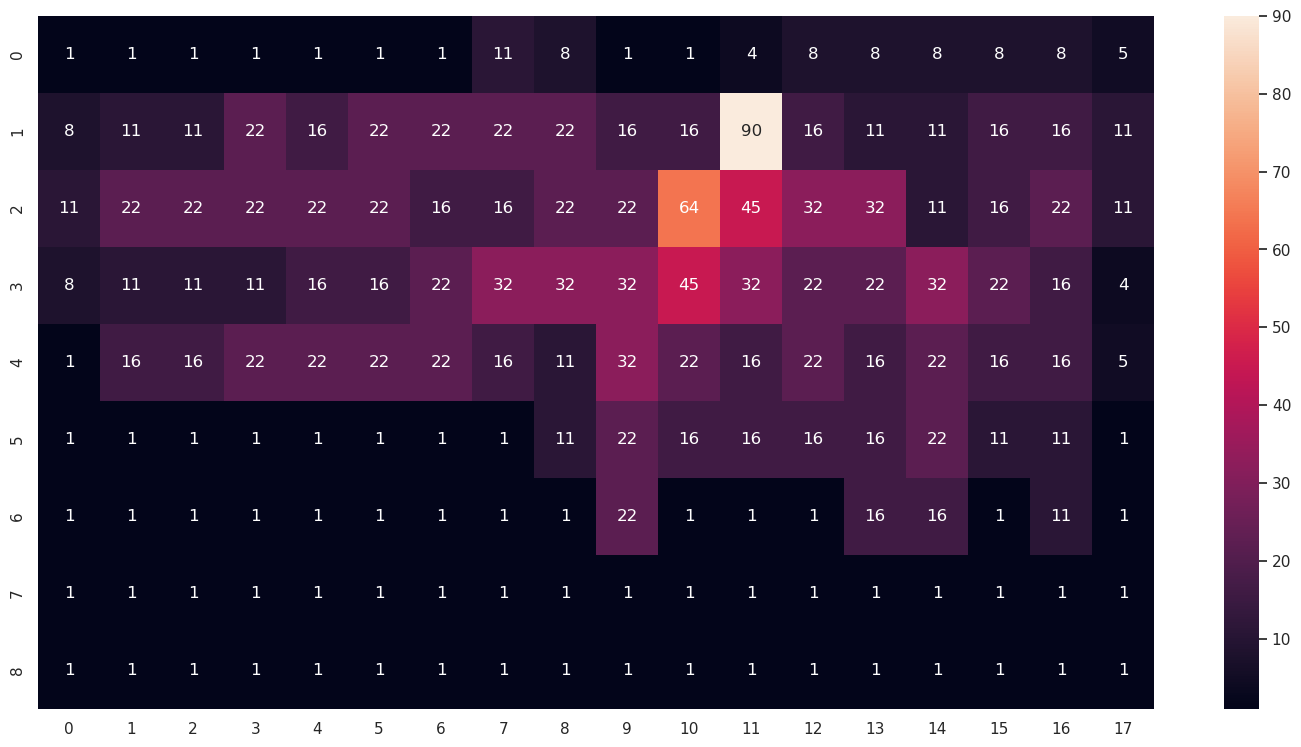

In [9]:
# Todo: visualize tiles with mistrack.
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

print(max_track.shape)
    

sns.set_theme(rc={'figure.figsize':(18,9)})
    
# plotting the heatmap 
hm = sns.heatmap(data=max_track.astype(int), annot=True, fmt="0d") 
    
# displaying the plotted heatmap 
plt.show()

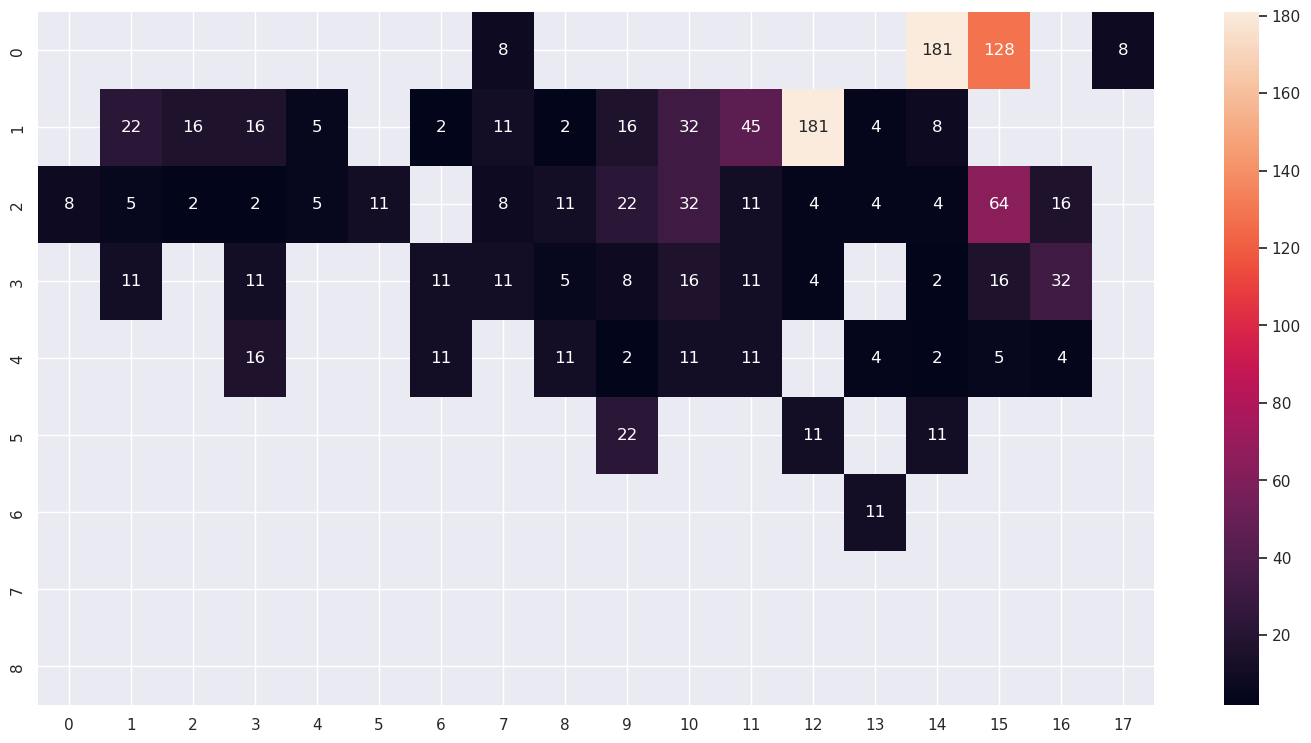

In [20]:
sns.set_theme(rc={'figure.figsize':(18,9)})

mmt = min_misstrack.copy()
mmt = mmt.astype(float)
# mmt[mmt == 1000] = np.nan
for i in range(mmt.shape[0]):
    for j in range(mmt.shape[1]):
        if mmt[i, j] == 1000:
            mmt[i, j] = np.nan
    
# plotting the heatmap 
hm = sns.heatmap(data=mmt, annot=True, fmt=".0f") 
    
# displaying the plotted heatmap 
plt.show()